In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as prog_bar

import os

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import sys

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


import seaborn as sns
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
# from tensorflow.keras.callbacks import ModelCheckpoint

### Random States
---

In [8]:
random_states =( 10,13,17,24,51)

In [9]:
cg = ('a','b','c','d') #categories

In [10]:
TTS_DICT = {
        'a':['50','50'],
        'b':['60',"40"],
        'c':['75','25'],
        'd':['80','20']
    }

TTS_DICT_INV = {
        '50':'a',
        '40':'b',
        '25':'c',
        '20':'d'    
    }

print(TTS_DICT_INV)

TTS_BASE_DIR = os.path.abspath('Train_Test_Data_Splits')
TTS_Folder_LIST = os.listdir(TTS_BASE_DIR)
print(TTS_Folder_LIST)

{'50': 'a', '40': 'b', '25': 'c', '20': 'd'}
['train_test_rs_10', 'train_test_rs_13', 'train_test_rs_17', 'train_test_rs_24', 'train_test_rs_51']


In [21]:
def get_train_test_xy():
    

    for tts_foldr in TTS_Folder_LIST:
        OHEs = {}
        Scalers = {}
        for x in cg:
            Scalers[x] = StandardScaler()
            OHEs[x] = OneHotEncoder()
        
        x_trains = {}
        y_trains= {}
        x_tests = {}
        y_tests = {}
        TTS_FILE_LIST = os.listdir(os.path.join(TTS_BASE_DIR,tts_foldr))
        for tts_file in TTS_FILE_LIST:
            tts_file_path = os.path.join(TTS_BASE_DIR,tts_foldr,tts_file)
            df = pd.read_csv(tts_file_path,index_col=False)
            tts_file_wo_ext = tts_file.split('.')[0].split('_')
            k = TTS_DICT_INV[tts_file_wo_ext[-1]]
            if 'train' in tts_file_wo_ext:
                #depend on test set size
                x_trains[k]  = Scalers[k].fit_transform(df.iloc[:,:-1].values)
                x_trains[k] = np.expand_dims(x_trains[k], axis=2)
                y_trains[k]  = OHEs[k].fit_transform(df['Y_train'].values.reshape(-1,1)).toarray()
            else:
                x_tests[k]  = Scalers[k].fit_transform(df.iloc[:,:-1].values)
                x_tests[k] = np.expand_dims(x_tests[k], axis=2)
                y_tests[k]  = OHEs[k].fit_transform( df['Y_test'].values.reshape(-1,1)).toarray()
        r_state = tts_foldr.split("_")[-1]
        yield (x_trains,y_trains,x_tests,y_tests,r_state)    
            
        

In [40]:

def loss_accuracy_details(model,history,epoch,x_test,y_test):
    acc = model.evaluate(x_test,y_test)[1]*100
    print(f"Accuracy of our model on test data :{acc:.2f} %")
    
    epochs = [i for i in range(epoch)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    test_acc = history.history['val_accuracy']
    test_loss = history.history['val_loss']

    fig.set_size_inches(20,6)
    ax[0].plot(epochs , train_loss , label = 'Training Loss')
    ax[0].plot(epochs , test_loss , label = 'Testing Loss')
    ax[0].set_title('Training & Testing Loss')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")

    ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
    ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
    ax[1].set_title('Training & Testing Accuracy')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    plt.show()
    return acc

---
### Base Model Folder path
----

In [28]:
MODEL_BASE_DIR = os.path.abspath('Models')

---
## Model 1
----

In [31]:
def model_1(x_train):
    model=Sequential()
    model.add(Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=3, strides = 1, padding = 'same'))

    model.add(Conv1D(128, kernel_size=5, strides=2, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Dropout(0.25))


    model.add(Flatten())
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(0.25))


    model.add(Dense(units=8, activation='softmax'))
    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
    return model

----
# Model 1 Traing For Different Train Test Split
  Train    |   Test
  - 50-50
  - 60-50
  - 75-25
  - 80-20
----

In [41]:
if not os.path.isdir(os.path.join(MODEL_BASE_DIR,'model_1')):
    os.mkdir(os.path.join(MODEL_BASE_DIR,'model_1'))

In [42]:
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.45, verbose=1, patience=2, min_lr=0.0000001)
epoch = 50

In [45]:
model_1_acc_matrix = {}
for k in cg:
   model_1_acc_matrix[k]= list()
print(model_1_acc_matrix) 
 

{'a': [], 'b': [], 'c': [], 'd': []}


In [ ]:
for x_trains,y_trains,x_tests,y_tests,rs in prog_bar(get_train_test_xy(),total=5):
    Model_1_dict = {}
    Histories_1 = {}
    for k in cg:
        Model_1_dict[k] = model_1(x_trains[k])
        print(f"Random State : = {rs}")
        print("-------------------")
        print(f"Traing is done for Model 1")
        print('-------------------------')
        print(f'Training set percentage : {TTS_DICT[k][0]}%')
        print(f'Testing set percentage  : {TTS_DICT[k][1]}%')
        print('---------------------------')
        Histories_1[k] = Model_1_dict[k].fit(x_trains[k], y_trains[k], 
                                    batch_size=64, 
                                    epochs=epoch, 
                                    validation_split=.25, 
                                    callbacks=[rlrp])
        
        
        print("-------------------")
        print(f"Traing is done for Model 1")
        print('-------------------------')
        print(f'Training set percentage : {TTS_DICT[k][0]}%')
        print(f'Testing set percentage  : {TTS_DICT[k][1]}%')
        print('---------------------------')
        
        model_1_acc_matrix[k].append(loss_accuracy_details(Model_1_dict[k],Histories_1[k],epoch,x_tests[k],y_tests[k]))
        
        if not os.path.isdir(os.path.join(MODEL_BASE_DIR,'model_1',k)):
            os.mkdir(os.path.join(MODEL_BASE_DIR,'model_1',k))
        Model_1_dict[k].save(os.path.join("Models",'model_1',k,f"model_1_{'_'.join(TTS_DICT[k])}_{rs}.h5"))

In [ ]:
model_1_acc_Df = pd.DataFrame(model_1_acc_matrix,index=random_states).T
path_to_model_acc_matrix = os.path.abspath('Model_Acc_Matrices')
model_1_acc_Df.to_csv(os.path.join(path_to_model_acc_matrix,'model_1_acc_mat.csv'))
model_1_acc_Df.head()

In [48]:
# a = {
#         'a':[1,2,3],
#         'b': [2,35,5],
#         'c': [1,3,5]
#     }
# rnd_df = pd.DataFrame(a,index=(13,17,20)).T
# rnd_df

,13,17,20
a,1,2,3
b,2,35,5
c,1,3,5


----
# Model 2
----

In [77]:
if not os.path.isdir(os.path.join(MODEL_BASE_DIR,'model_2')):
    os.mkdir(os.path.join(MODEL_BASE_DIR,'model_2'))

In [76]:
Model_2_dict = {}
Histories_2 = {}

In [79]:
def model_2(x_train):
    model=Sequential()
    model.add(Conv1D(128, kernel_size=7, strides=3, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))

    model.add(Conv1D(128, kernel_size=5, strides=2, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=7, strides = 2, padding = 'same'))
    model.add(Dropout(0.35))

    model.add(Flatten())
    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(0.3))


    model.add(Dense(units=8, activation='softmax'))
    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

    return model

In [80]:
Model_2_dict = {}
for k in cg:
    Model_2_dict[k] = model_2(x_trains[k])

In [83]:
for k in cg:
    print("-------------------")
    print(f"Traing is going on for Model 2")
    print('-------------------------')
    print(f'Training set percentage : {TTS_DICT[k][0]}%')
    print(f'Testing set percentage  : {TTS_DICT[k][1]}%')
    print('---------------------------')
    Histories_2[k] = Model_2_dict[k].fit(x_trains[k], y_trains[k], 
                                batch_size=64, 
                                epochs=epoch, 
                                validation_split=.25, 
                                callbacks=[rlrp])
    
    Model_2_dict[k].save(os.path.join("Models",'model_2',f"model_2_{'_'.join(TTS_DICT[k])}.h5"))

-------------------
Traing is going on for Model 2
-------------------------
Training set percentage : 50%
Testing set percentage  : 50%
---------------------------
Epoch 1/40
26/26 [==============================] - 1s 28ms/step - loss: 1.9935 - accuracy: 0.1914 - val_loss: 1.8731 - val_accuracy: 0.2722
Epoch 2/40
26/26 [==============================] - 0s 8ms/step - loss: 1.8834 - accuracy: 0.2500 - val_loss: 1.8050 - val_accuracy: 0.3019
Epoch 3/40
26/26 [==============================] - 0s 9ms/step - loss: 1.8045 - accuracy: 0.2728 - val_loss: 1.7169 - val_accuracy: 0.3130
Epoch 4/40
26/26 [==============================] - 0s 7ms/step - loss: 1.7257 - accuracy: 0.3222 - val_loss: 1.6388 - val_accuracy: 0.3611
Epoch 5/40
26/26 [==============================] - 0s 18ms/step - loss: 1.6508 - accuracy: 0.3679 - val_loss: 1.5989 - val_accuracy: 0.3704
Epoch 6/40
26/26 [==============================] - 0s 7ms/step - loss: 1.5922 - accuracy: 0.3988 - val_loss: 1.5639 - val_accuracy: 

-------------------
Traing is done for Model 1
-------------------------
Training set percentage : 50%
Testing set percentage  : 50%
---------------------------
68/68 [==============================] - 0s 2ms/step - loss: 1.0090 - accuracy: 0.7023
Accuracy of our model on test data :  70.23147940635681 %


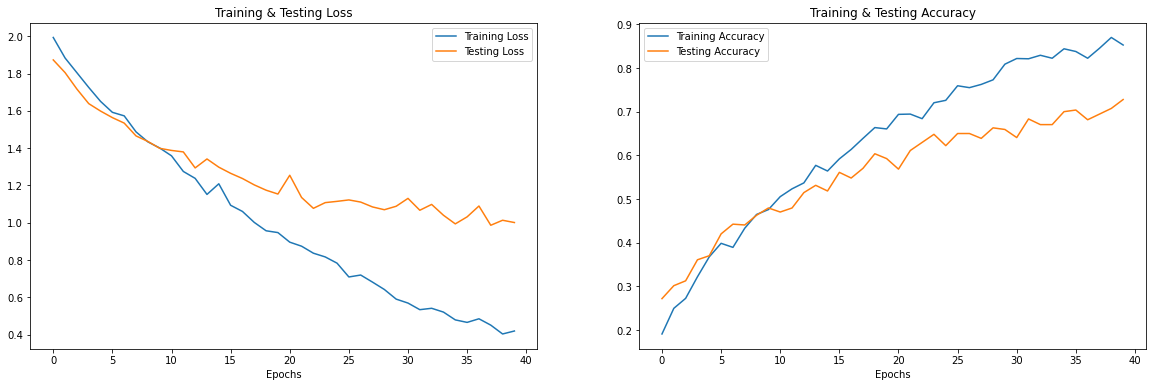

-------------------
Traing is done for Model 1
-------------------------
Training set percentage : 60%
Testing set percentage  : 40%
---------------------------
54/54 [==============================] - 0s 4ms/step - loss: 0.8330 - accuracy: 0.7541
Accuracy of our model on test data :  75.40509104728699 %


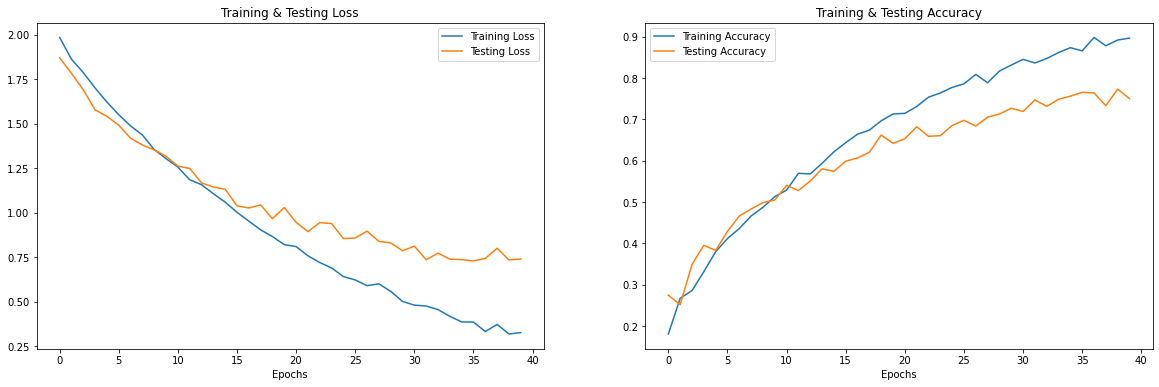

-------------------
Traing is done for Model 1
-------------------------
Training set percentage : 80%
Testing set percentage  : 20%
---------------------------
27/27 [==============================] - 0s 2ms/step - loss: 0.6484 - accuracy: 0.7859
Accuracy of our model on test data :  78.58796119689941 %


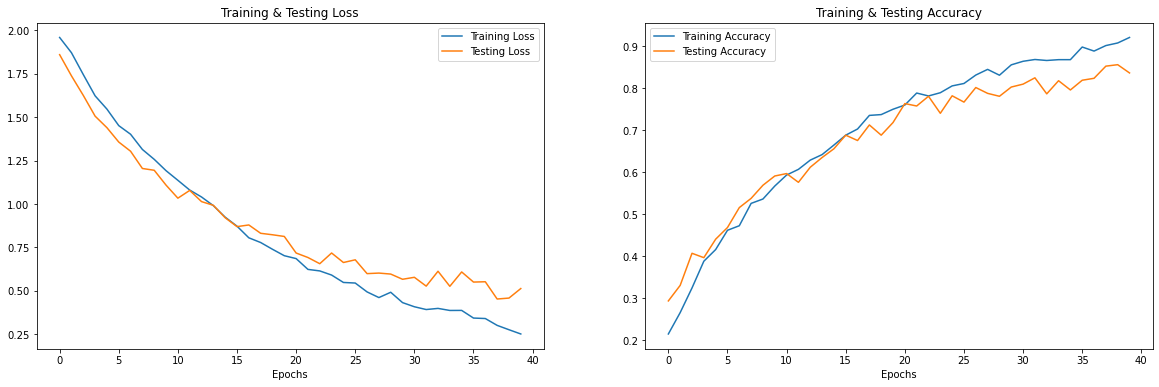

-------------------
Traing is done for Model 1
-------------------------
Training set percentage : 75%
Testing set percentage  : 25%
---------------------------
34/34 [==============================] - 0s 2ms/step - loss: 0.6246 - accuracy: 0.8037
Accuracy of our model on test data :  80.37037253379822 %


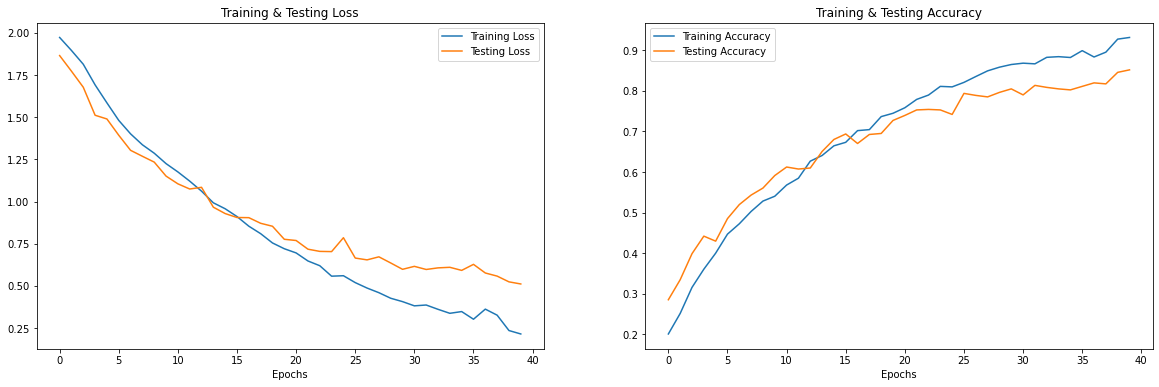

In [84]:
for k in cg:
    print("-------------------")
    print(f"Traing is done for Model 1")
    print('-------------------------')
    print(f'Training set percentage : {TTS_DICT[k][0]}%')
    print(f'Testing set percentage  : {TTS_DICT[k][1]}%')
    print('---------------------------')
    loss_accuracy_details(Model_2_dict[k],Histories_2[k],epoch,x_tests[k],y_tests[k])

---
# Model 3 Training Testing
---

In [90]:
if not os.path.isdir(os.path.join(MODEL_BASE_DIR,'model_3')):
    os.mkdir(os.path.join(MODEL_BASE_DIR,'model_3'))

In [91]:
Model_3_dict = {}
Histories_3 = {}

In [94]:
def model_3(x_train):
    model=Sequential()
    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=3, strides = 3, padding = 'same'))

    model.add(Conv1D(256, kernel_size=9, strides=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=7, strides = 5, padding = 'same'))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.3))


    model.add(Dense(units=8, activation='softmax'))
    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
    return model


In [95]:
Model_3_dict = {}
for k in cg:
    Model_3_dict[k] = model_3(x_trains[k])

In [96]:
for k in cg:
    print("-------------------")
    print(f"Traing is going on for Model 3")
    print('-------------------------')
    print(f'Training set percentage : {TTS_DICT[k][0]}%')
    print(f'Testing set percentage  : {TTS_DICT[k][1]}%')
    print('---------------------------')
    Histories_3[k] = Model_3_dict[k].fit(x_trains[k], y_trains[k], 
                                batch_size=64, 
                                epochs=epoch, 
                                validation_split=.25, 
                                callbacks=[rlrp])
    
    Model_3_dict[k].save(os.path.join("Models",'model_3',f"model_3_{'_'.join(TTS_DICT[k])}.h5"))

-------------------
Traing is going on for Model 2
-------------------------
Training set percentage : 50%
Testing set percentage  : 50%
---------------------------
Epoch 1/40
26/26 [==============================] - 2s 53ms/step - loss: 1.9615 - accuracy: 0.2154 - val_loss: 1.8267 - val_accuracy: 0.3259
Epoch 2/40
26/26 [==============================] - 1s 56ms/step - loss: 1.8013 - accuracy: 0.3117 - val_loss: 1.7263 - val_accuracy: 0.3463
Epoch 3/40
26/26 [==============================] - 1s 53ms/step - loss: 1.6860 - accuracy: 0.3593 - val_loss: 1.6361 - val_accuracy: 0.4426
Epoch 4/40
26/26 [==============================] - 1s 52ms/step - loss: 1.5809 - accuracy: 0.4086 - val_loss: 1.5186 - val_accuracy: 0.4389
Epoch 5/40
26/26 [==============================] - 1s 43ms/step - loss: 1.5302 - accuracy: 0.4136 - val_loss: 1.4821 - val_accuracy: 0.4407
Epoch 6/40
26/26 [==============================] - 1s 43ms/step - loss: 1.4437 - accuracy: 0.4562 - val_loss: 1.4163 - val_accura

-------------------
Traing is done for Model 3
-------------------------
Training set percentage : 50%
Testing set percentage  : 50%
---------------------------
68/68 [==============================] - 0s 6ms/step - loss: 1.1036 - accuracy: 0.7657
Accuracy of our model on test data :  76.57407522201538 %


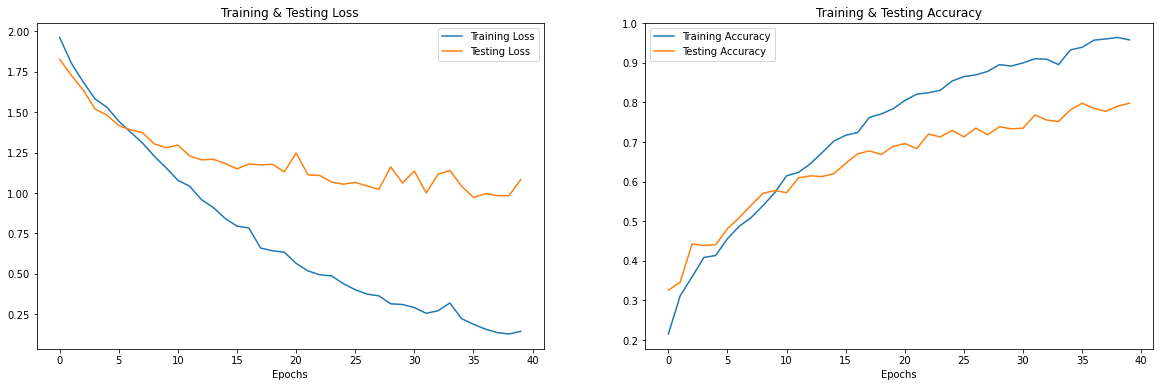

-------------------
Traing is done for Model 3
-------------------------
Training set percentage : 60%
Testing set percentage  : 40%
---------------------------
54/54 [==============================] - 0s 6ms/step - loss: 0.8047 - accuracy: 0.7870
Accuracy of our model on test data :  78.70370149612427 %


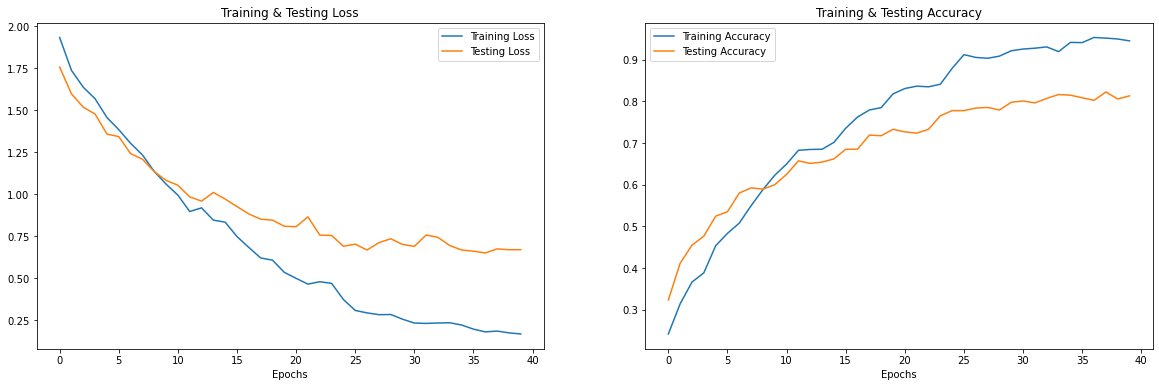

-------------------
Traing is done for Model 3
-------------------------
Training set percentage : 80%
Testing set percentage  : 20%
---------------------------
27/27 [==============================] - 0s 8ms/step - loss: 0.5519 - accuracy: 0.8426
Accuracy of our model on test data :  84.25925970077515 %


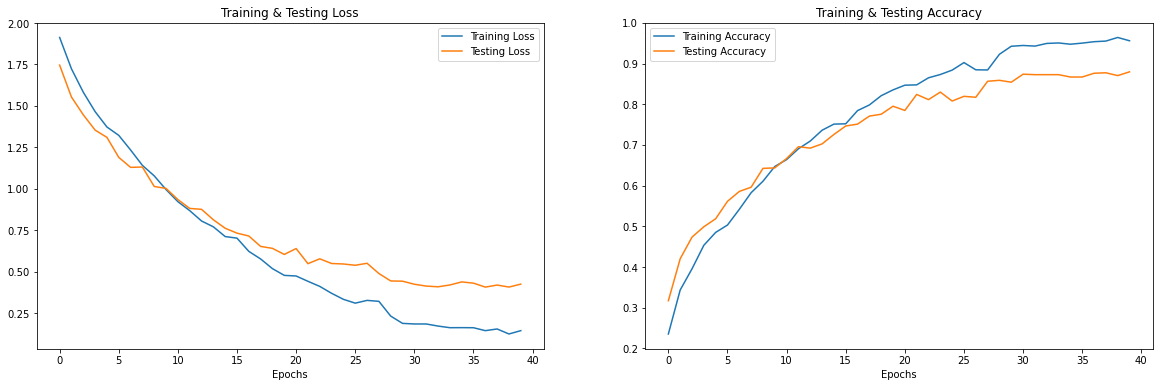

-------------------
Traing is done for Model 3
-------------------------
Training set percentage : 75%
Testing set percentage  : 25%
---------------------------
34/34 [==============================] - 0s 5ms/step - loss: 0.6091 - accuracy: 0.8444
Accuracy of our model on test data :  84.44444537162781 %


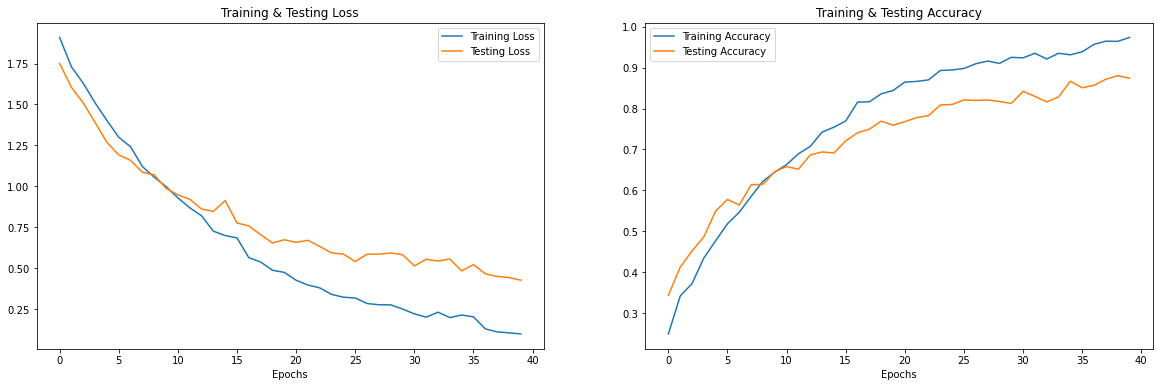

In [97]:
for k in cg:
    print("-------------------")
    print(f"Traing is done for Model 3")
    print('-------------------------')
    print(f'Training set percentage : {TTS_DICT[k][0]}%')
    print(f'Testing set percentage  : {TTS_DICT[k][1]}%')
    print('---------------------------')
    loss_accuracy_details(Model_3_dict[k],Histories_3[k],epoch,x_tests[k],y_tests[k])